 ## 2.3 索引的构建与管理  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/richzw/milvus-workshop/blob/main/ch2/ch2_3.ipynb)

 在前面的部分，我们学习了如何创建 Collection、插入数据和管理数据。现在，我们将深入探讨 Milvus 中一个至关重要的概念：**索引 (Index)**。索引是实现高效向量相似性搜索的核心。


 ### 概念：索引 (Index) - 加速向量相似度搜索的关键

 在大规模向量数据集中，逐个比较查询向量与数据库中所有向量以找到最相似的几个（即暴力搜索或精确搜索）是非常耗时且不切实际的。**索引**是一种特殊的数据结构，它通过对原始向量数据进行预处理和组织，从而能够在牺牲一定精度（对于近似搜索）或不牺牲精度（对于某些特定索引如 FLAT）的情况下，**极大地加速**相似性搜索的过程。

 - **目的**: 快速定位与查询向量相似的候选向量，减少需要进行精确距离计算的向量数量。
 - **权衡**: 大多数高性能索引（ANNS 索引）都是在搜索**速度**、**精度 (召回率)** 和 **构建索引的时间/资源** 之间进行权衡。

 ### 核心：近似最近邻搜索 (Approximate Nearest Neighbor Search, ANNS)

 对于海量高维向量数据，精确的最近邻搜索（ENN）通常计算成本过高。因此，Milvus 和许多其他向量数据库主要采用 **近似最近邻搜索 (ANNS)** 算法。

 - **ANNS**: 目标是在可接受的时间内找到“足够好”的近似结果，而不是保证找到绝对的最近邻。
 - **召回率 (Recall)**: ANNS 算法的一个重要评估指标，表示搜索结果中包含了多少比例的真实最近邻。通常，更高的召回率意味着更高的搜索精度，但也可能需要更多的计算资源和时间。
 - Milvus 支持多种 ANNS 索引算法，允许用户根据具体应用场景在速度和精度之间进行选择。

 ### 介绍常见的向量索引类型及其适用场景

 Milvus 支持多种向量索引类型，每种类型都有其特定的数据结构、算法和适用场景。以下是一些常见的索引类型：

 1.  **`FLAT` (或 `FLAT_NM` 在某些早期版本)**:

     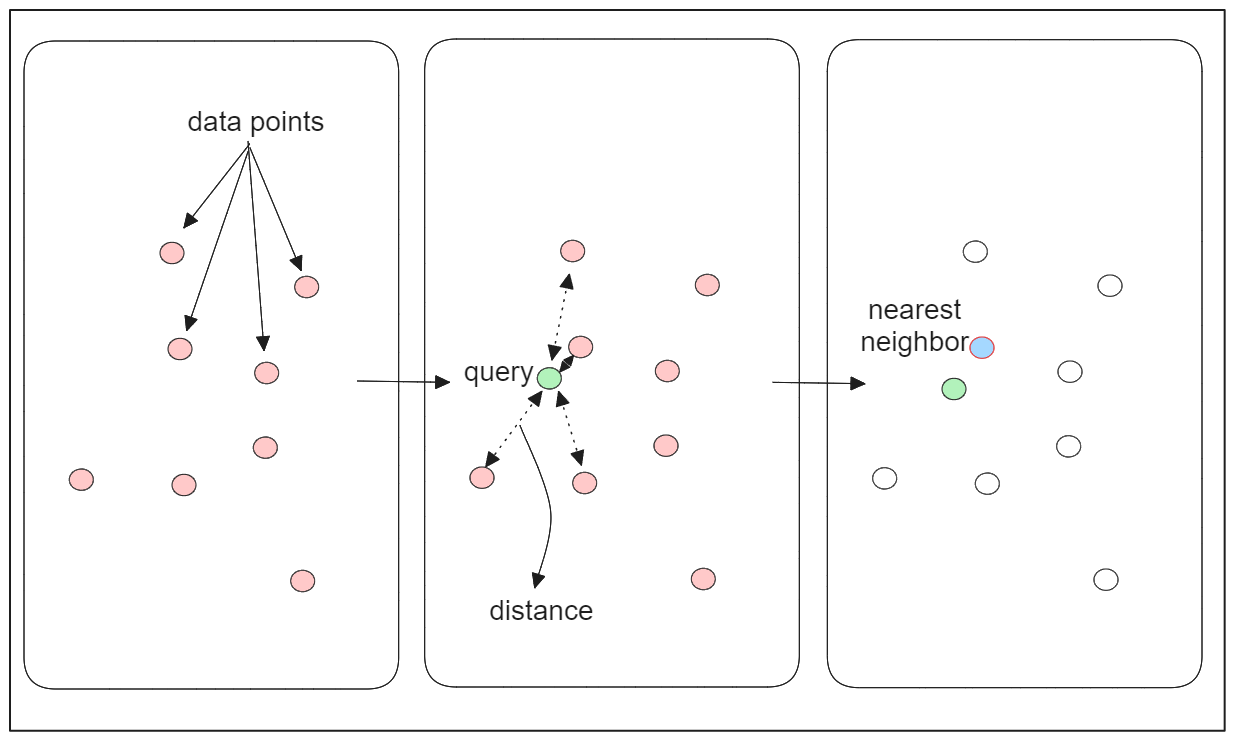
     *   **原理**: 不对原始向量数据进行任何压缩或聚类，直接进行精确的暴力搜索。
     *   **优点**: 100% 召回率（精确搜索）。
     *   **缺点**: 搜索速度非常慢，尤其当数据量很大时。内存占用也较大，因为它存储原始向量。
     *   **适用场景**: 数据量非常小（例如，几万条以内），或者对召回率有极致要求且能接受较慢查询速度的场景。通常用于小规模测试或与其他索引进行性能对比。

 3.  **`IVF_FLAT` (Inverted File with FLAT CQuantizer)**:

     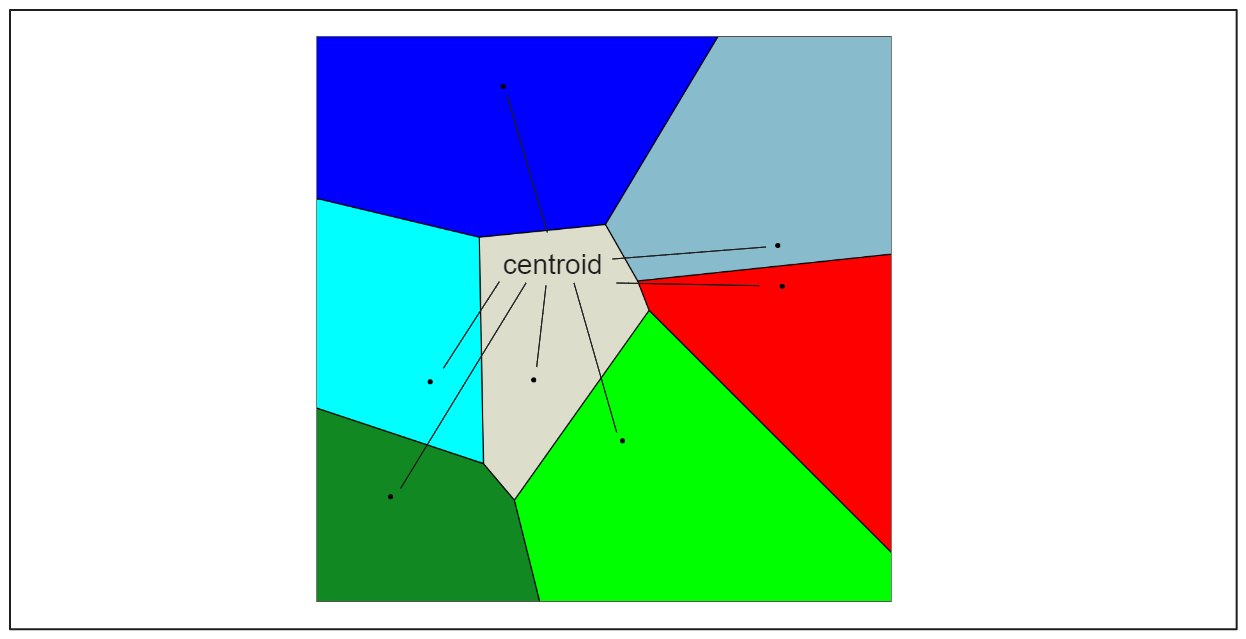
     *   **原理**:
         1.  **聚类 (Clustering)**: 首先使用 k-means 等算法将数据集中的向量划分成 `nlist` 个簇 (clusters)。每个簇有一个中心向量 (centroid)。
         2.  **倒排文件 (Inverted File)**: 创建一个倒排索引，将每个向量映射到其所属的簇。
         3.  **搜索**: 查询时，先找到查询向量最接近的 `nprobe` 个簇的中心，然后在这些选定的簇内使用 FLAT（暴力搜索）进行精确查找。
     *   **优点**: 比 FLAT 快得多，召回率相对较高。
     *   **缺点**: 性能受 `nlist` 和 `nprobe` 参数影响较大，需要调优。
     *   **参数**:
         *   `nlist`: 聚类中心的数量。通常建议值为 `4 * sqrt(N)` 到 `16 * sqrt(N)` (N 是总向量数)。
         *   `nprobe` (搜索参数): 查询时需要搜索的簇的数量。值越大，召回率越高，但速度越慢。
     *   **适用场景**: 对召回率有较高要求，且数据量适中到较大的场景。是一个很好的基准索引。

 5.  **`IVF_SQ8` (Inverted File with Scalar Quantization)**:
     *   **原理**: 与 `IVF_FLAT` 类似，但在簇内存储向量时，使用了标量量化 (Scalar Quantization) 对向量进行有损压缩，将每个浮点数维度量化为一个 8-bit 整数。
     *   **优点**: 相比 `IVF_FLAT`，显著减少了磁盘和内存占用，查询速度通常也更快（因为比较的是量化后的值）。
     *   **缺点**: 由于量化是有损的，召回率通常会略低于 `IVF_FLAT`。
     *   **参数**: `nlist` (同IVF_FLAT), `nprobe` (搜索参数)。
     *   **适用场景**: 对存储空间和内存占用敏感，且能接受轻微精度损失的场景。

 6.  **`IVF_PQ` (Inverted File with Product Quantization)**:
     *   **原理**: 类似于 `IVF_SQ8`，但在簇内使用乘积量化 (Product Quantization, PQ) 进行更高级的向量压缩。PQ 将原始向量分割成多个子向量，并对每个子向量分别进行量化。
     *   **优点**: 压缩率更高，内存占用更小。
     *   **缺点**: 召回率可能进一步下降，构建索引时间可能更长。参数调优更复杂（如 `m` - PQ的子空间数量，`nbits` - 每个子空间量化的位数）。
     *   **参数**: `nlist`, `nprobe`, `m`, `nbits`。
     *   **适用场景**: 极大限度地追求低内存占用和高吞吐量的场景，例如十亿级别的向量搜索。

 7.  **`HNSW` (Hierarchical Navigable Small World graphs)**:

     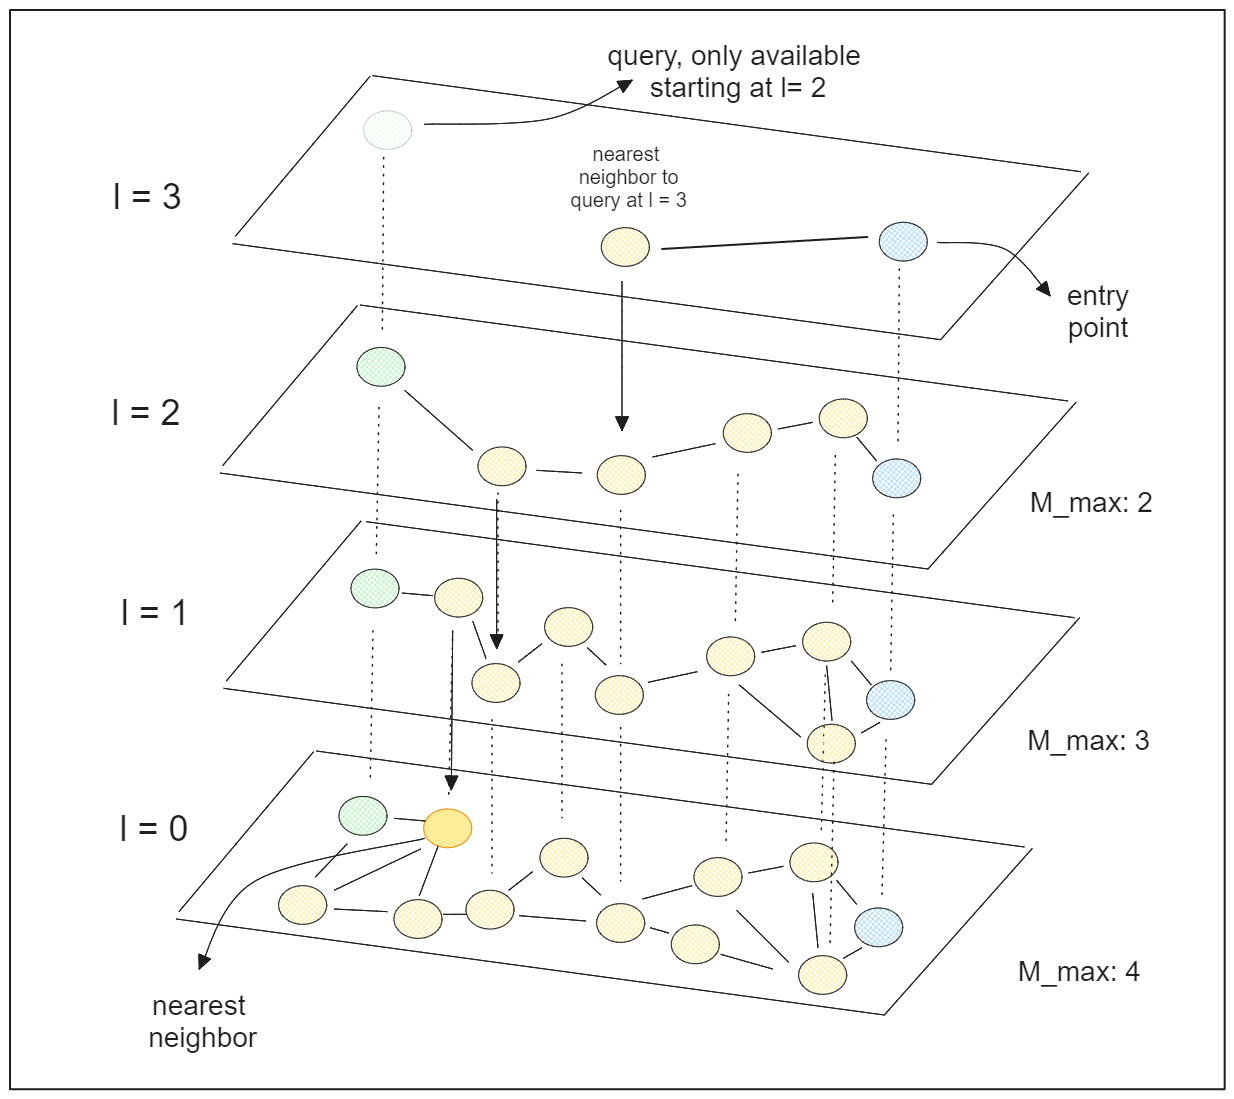
     *   **原理**: 一种基于图的 ANNS 算法。它构建一个多层的导航小世界图，其中上层图更稀疏，下层图更密集。搜索时从顶层图的入口点开始，逐步向查询向量的最近邻逼近。
     *   **优点**: 搜索性能通常非常好（高召回率和高QPS），对数据集分布不敏感，无需像 IVF 系列那样进行数据训练（聚类）。
     *   **缺点**: 构建索引时间相对较长，内存占用也相对较大（存储图结构和原始向量）。
     *   **参数**:
         *   `M`: 图中每个节点的最大出度（连接数）。值越大，图越密集，召回率越高，但构建时间和内存也增加。通常取 8-64。
         *   `efConstruction`: 构建索引时动态列表的大小（搜索范围）。值越大，索引质量越高，但构建时间越长。通常取 100-500。
         *   `ef` (搜索参数): 查询时动态列表的大小。值越大，召回率越高，但速度越慢。
     *   **适用场景**: 广泛适用于各种场景，特别是对搜索性能和召回率有较高要求的应用。是目前最流行的索引之一。

 **其他索引类型**: Milvus 还支持如 `DISKANN` (适用于磁盘存储的大规模数据集), `SCANN` 等，具体可查阅 Milvus 官方文档。

    * DiskANN是基于 Vamana 图结构，通过 PQ 压缩向量，在硬盘上建立可导航索引，适用于十亿级数据集


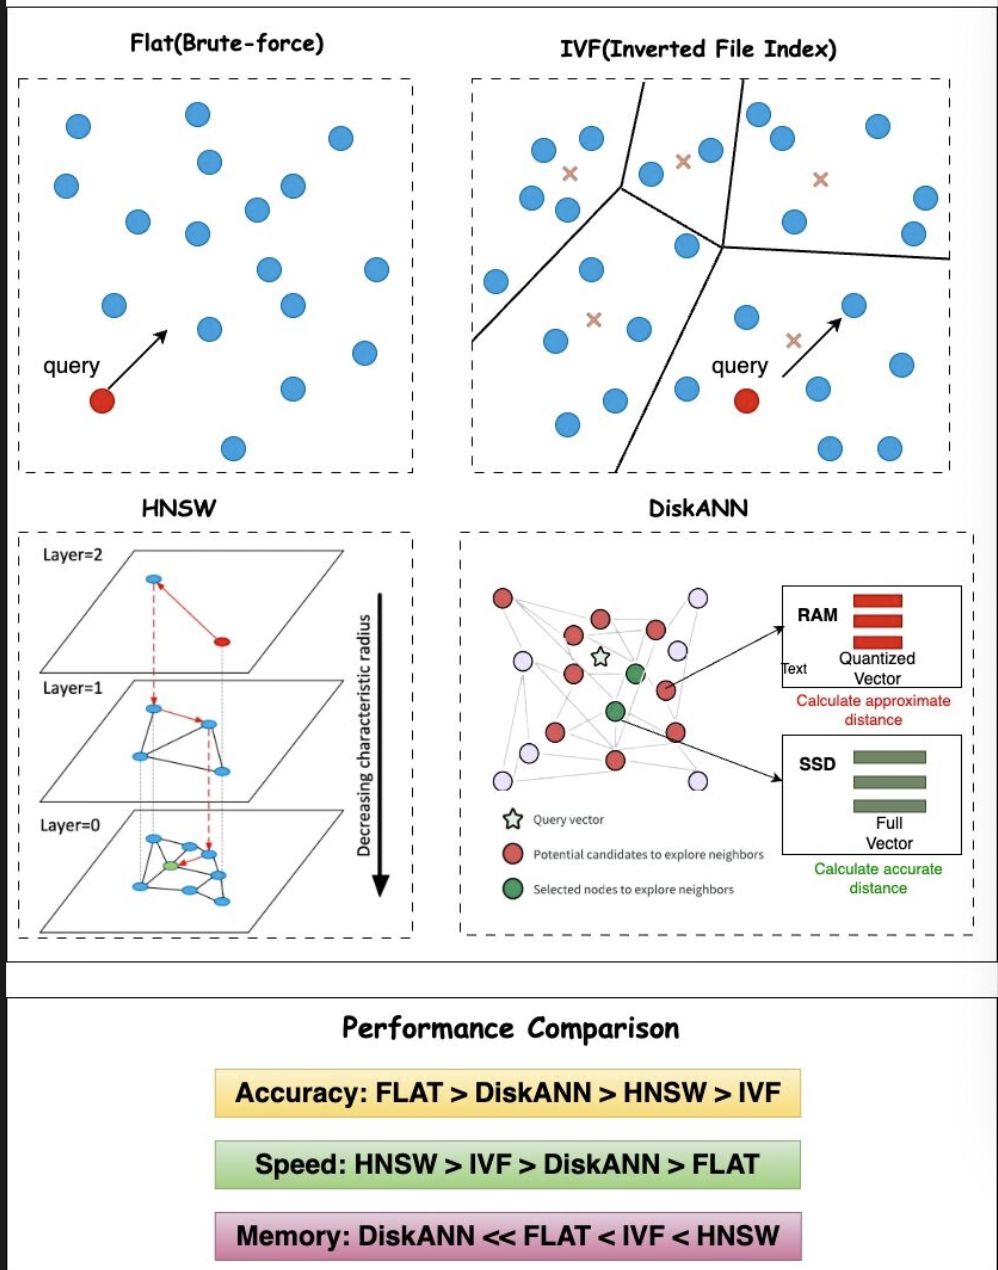


 ### 介绍距离度量 (Distance Metrics)

 距离度量（或相似度度量）用于衡量两个向量之间的“远近”或“相似”程度。在创建索引和执行搜索时，必须指定一个与您的数据和应用场景相匹配的度量方式。

 1.  **欧氏距离 (Euclidean Distance, `L2`)**:
     *   **公式**: $d = \sqrt{\sum_{i=1}^{n}(A_i - B_i)^2}$
     *   **含义**: 向量空间中两点之间的直线距离。值越小，向量越相似。
     *   **适用场景**: 适用于大多数通用场景，特别是当向量的绝对大小和方向都很重要时，例如图像特征向量。

 2.  **内积 (Inner Product, `IP`)**:
     *   **公式**: $d = \sum_{i=1}^{n}(A_i \cdot B_i)$
     *   **含义**: 衡量两个向量方向上的一致性以及幅度的乘积。值越大，向量越相似。
     *   **适用场景**: 适用于向量方向比绝对大小更重要的场景。例如，推荐系统中用户和物品的嵌入向量。

 3.  **余弦相似度 (Cosine Similarity)**:
     *   **公式**: $similarity = \frac{\sum_{i=1}^{n}(A_i \cdot B_i)}{\sqrt{\sum_{i=1}^{n}A_i^2} \cdot \sqrt{\sum_{i=1}^{n}B_i^2}}$
     *   **含义**: 衡量两个向量方向之间的夹角的余弦值。值在 [-1, 1] 或 [0, 1] (如果向量非负) 之间，值越大（越接近1），向量方向越相似。
     *   **与 IP 的关系**: 如果所有向量都经过归一化 (L2-normalize，即长度为1)，则 IP 等价于余弦相似度。Milvus 在使用 `IP` 度量时，如果向量未归一化，它计算的是纯内积。要获得真正的余弦相似度，**您需要在插入数据前对向量进行归一化处理**。
     *   **适用场景**: 文本相似度 (如 TF-IDF, Word Embeddings)，当向量的长度不重要，只关心方向时。

 **如何选择？**

 - **模型来源**: 最重要的是，选择与您生成向量嵌入（Embeddings）时所用模型的目标函数或相似性度量相一致的度量方式。例如，如果模型是用欧氏距离优化的，那么在 Milvus 中也应该用 `L2`。
 - **数据特性**: 考虑您的数据特性。如果向量长度有实际意义，`L2` 可能更合适。如果只关心方向，`IP` (配合归一化向量以实现余弦相似度) 可能更好。
 - **实验验证**: 如果不确定，可以尝试不同的度量方式，并评估它们在您的验证集上的表现。

 ### 实操：为 Vector Field 创建索引

 我们将为之前练习中创建的 `book_search_mc` Collection 的 `book_embedding` 字段创建一个 HNSW 索引。

 **前提**:
 1.  Milvus 服务已连接 (`client` 对象可用)。
 2.  `book_search_mc` Collection 已创建，并且**已插入一些数据**以及完成 `flush` 动作。索引是基于现有数据构建的。

In [1]:
# 确保 MilvusClient 'client' 已经从前面部分初始化并连接
from pymilvus import MilvusClient
MILVUS_URI = "http://localhost:19530"
client = MilvusClient(uri=MILVUS_URI)

# 定义 Collection 和字段名称
COLLECTION_NAME_INDEX_EXERCISE = "book_search"
VECTOR_FIELD_NAME_INDEX_EXERCISE = "book_embedding" # Schema 中定义的向量字段名

# 1. 检查 Collection 是否存在且有数据
try:
    if not client.has_collection(collection_name=COLLECTION_NAME_INDEX_EXERCISE):
        print(f"错误: Collection '{COLLECTION_NAME_INDEX_EXERCISE}' 不存在。请先运行前面的练习创建并插入数据。")
        raise ValueError(f"Collection '{COLLECTION_NAME_INDEX_EXERCISE}' not found for indexing.")

    stats = client.get_collection_stats(collection_name=COLLECTION_NAME_INDEX_EXERCISE)
    num_entities_for_index = int(stats.get('row_count', 0))
    print(f"Collection '{COLLECTION_NAME_INDEX_EXERCISE}' 中当前实体数量: {num_entities_for_index}")
    if num_entities_for_index == 0:
        print(f"警告: Collection '{COLLECTION_NAME_INDEX_EXERCISE}' 中没有数据，创建的索引将为空。建议先插入数据。")
        # 通常，在没有数据的情况下创建索引的意义不大，但 Milvus 允许这样做。
        # 索引会在数据插入并 flush 后自动更新（如果配置了自动构建或手动触发）。

except Exception as e:
    print(f"检查 Collection 状态时发生错误: {e}")
    raise

ModuleNotFoundError: No module named 'pymilvus'

In [2]:
# 2. 定义索引参数
# 我们选择 HNSW 索引，使用 L2 距离
# 对于 Workshop，我们使用较小的参数以加快构建速度
hnsw_index_params = MilvusClient.prepare_index_params()

hnsw_index_params.add_index(
    field_name=VECTOR_FIELD_NAME_INDEX_EXERCISE,
    metric_type="L2",
    index_type="HNSW",
    index_name="idx_book_embedding_hnsw",
    params={
        "M": 8,              # 每个节点的最大连接数 (较小值，构建快)
        "efConstruction": 100 # 构建图时的搜索范围 (较小值，构建快)
    }
)

VECTOR_INDEX_NAME='vector_index'

# 3. 创建索引
try:
    print(f"\n准备为 Collection '{COLLECTION_NAME_INDEX_EXERCISE}' 的字段 '{VECTOR_FIELD_NAME_INDEX_EXERCISE}' 创建索引...")

    # (可选) 检查并删除旧索引，以确保使用新参数
    name_indexes = client.list_indexes(collection_name=COLLECTION_NAME_INDEX_EXERCISE)
    index_exists_for_field = any(idx_name == VECTOR_INDEX_NAME for idx_name in name_indexes)

    if index_exists_for_field:
        print(f"字段 '{VECTOR_FIELD_NAME_INDEX_EXERCISE}' 上已存在索引。将删除旧索引并使用新参数重新创建。")
        client.release_collection(collection_name=COLLECTION_NAME_INDEX_EXERCISE)
        try:
            client.drop_index(collection_name=COLLECTION_NAME_INDEX_EXERCISE, index_name=VECTOR_INDEX_NAME)
            print(f"字段 '{VECTOR_FIELD_NAME_INDEX_EXERCISE}' 上的旧索引已删除。")
        except Exception as drop_e:
            print(f"删除旧索引失败 (可能由于版本或权限问题): {drop_e}")
            print("将继续尝试创建新索引...") # 即使删除失败，也尝试创建

    print(f"使用参数创建 HNSW 索引: {hnsw_index_params}")
    client.create_index(
        collection_name=COLLECTION_NAME_INDEX_EXERCISE,
        index_params=hnsw_index_params,
        sync=False 
    )
    print(f"索引创建请求已成功发送至 Milvus。")
    print("索引构建是异步的，请稍后检查状态。")

except Exception as e:
    print(f"创建索引失败: {e}")
    raise


准备为 Collection 'book_search' 的字段 'book_embedding' 创建索引...
使用参数创建 HNSW 索引: [{'field_name': 'book_embedding', 'index_type': 'HNSW', 'index_name': 'idx_book_embedding_hnsw', 'M': 8, 'efConstruction': 100, 'metric_type': 'L2'}]
索引创建请求已成功发送至 Milvus。
索引构建是异步的，请稍后检查状态。


 ### 实操：查看索引状态

 索引创建是异步的。我们可以使用以下方法来查看索引的信息和构建进度。

In [3]:
from pymilvus import connections, utility

# Connection to localhost:19530
connections.connect()

try:
    print(f"\n查看 Collection '{COLLECTION_NAME_INDEX_EXERCISE}' 上的索引信息:")
    indexes_names = client.list_indexes(collection_name=COLLECTION_NAME_INDEX_EXERCISE)
    if not indexes_info:
        print("当前 Collection 上没有索引。")
    else:
        for idx_name in indexes_names: 
            idx_info_dict = client.describe_index(collection_name=COLLECTION_NAME_INDEX_EXERCISE, index_name=idx_name)
            # idx_info_dict 是一个 OmitZeroDict，可以像普通字典一样访问
            print(f"  - 索引名称: {idx_info_dict.get('index_name', 'N/A')}") # 使用 .get() 更安全
            print(f"    字段名: {idx_info_dict.get('field_name')}")
            print(f"    所有行数: {idx_info_dict.get('total_rows')}") 
            print(f"    索引行数: {idx_info_dict.get('indexed_rows')}") 
            print(f"    正在索引行数: {idx_info_dict.get('pending_index_rows')}") 
    

            print(f"\n查看字段 '{VECTOR_FIELD_NAME_INDEX_EXERCISE}' 上的索引构建进度:")
            index_progress = utility.index_building_progress(
                collection_name=COLLECTION_NAME_INDEX_EXERCISE,
                index_name=idx_name
            )
            print(f"  总行数 (Total rows for indexing): {index_progress.get('total_rows', 'N/A')}")
            print(f"  已索引行数 (Indexed rows): {index_progress.get('indexed_rows', 'N/A')}")
            print(f"  待索引行数 (Pending index rows): {index_progress.get('pending_index_rows', 'N/A')}")
            
            if index_progress.get('total_rows', 0) > 0 and index_progress.get('indexed_rows') == index_progress.get('total_rows') and index_progress.get('pending_index_rows', 0) == 0:
                print("  状态: 索引已构建完成！")
            elif index_progress.get('total_rows', 0) == 0 and index_progress.get('indexed_rows', 0) == 0 :
                 print("  状态: Collection 中可能没有数据，或索引尚未开始处理数据。")
            else:
                print("  状态: 索引仍在构建中或部分完成。")

except Exception as e:
    print(f"查看索引信息或进度时发生错误: {e}")


查看 Collection 'book_search' 上的索引信息:
查看索引信息或进度时发生错误: name 'indexes_info' is not defined


 ### [我应该选择哪种向量索引？](https://mp.weixin.qq.com/s/yJIHKfUOAtz4iWVHURri9g)

- **字段类型与可用索引类型的对应关系**:

 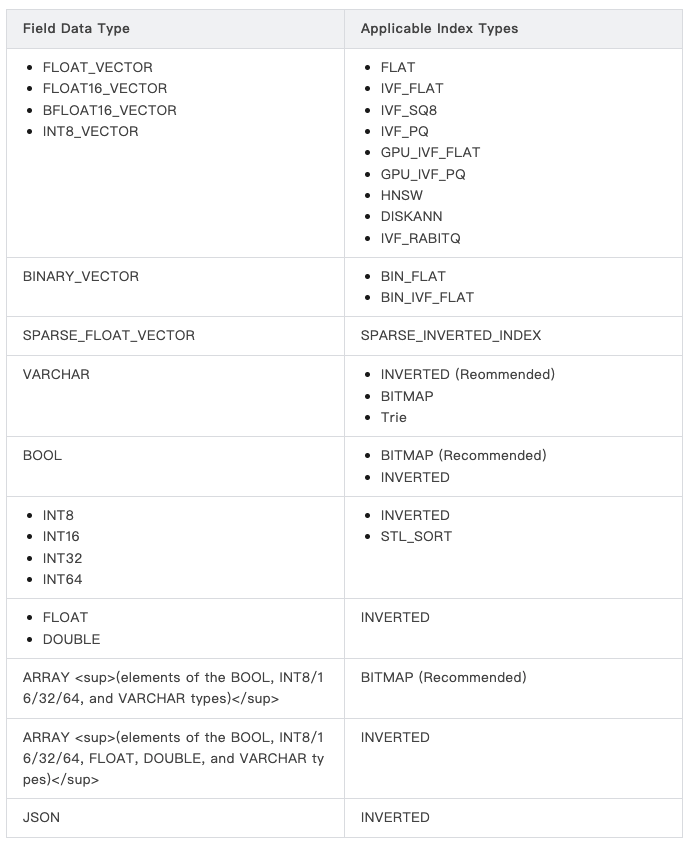

- **Rule**: “早启动 > 慢精调”。因此，Milvus 提供了 AutoIndex。

  - AutoIndex
    - 对于标量字段，根据字段类型自动选择索引（如数字字段用字典树，字符串用倒排索引），可以间接推断。
    - 对于向量字段，实际索引类型由 Milvus 内部决定; 默认使用 HNSW

--------

- 我们习惯把索引划分成“内存型”“磁盘型”“GPU型”，接下来就从这三种出发来聊一聊。

  - **关于内存索引：检索速度最快，但内存成本高**。常见的IVF_FLAT、HNSW等索引目前Milvus全都支持。此外，大多数索引会量化向量以减少内存使用量，但需要内存来存储额外的数据结构。其他非向量数据（标量）及其索引也会占用内存空间。

  - **关于磁盘索引：如果我们需要处理数十亿向量，又没有海量内存的时候，可以使用DiskANN 和 MMap** 。DiskANN 可以将未压缩向量+图搜索结构放在磁盘上，只在内存中维护高度压缩副本。当然，“低延迟”有前提——你需要使用 NVMe 硬盘（毕竟，SATA 的性能会让你怀疑人生）而 MMap 则是用虚拟内存机制将索引根据需要在磁盘和内存之间交换。这样，如果每次只使用一小部分数据，也能加载完整的索引，但频繁的页面交换会导致延迟过高。很多做日志回放、长尾分析的用户，反而偏爱这种“按需加载”的方式

  - **关于GPU 索引：GPU 的好处是并行、多线程、吞吐强，但缺点也很明显：调度复杂、成本更高、代码链路更难维护**。Milvus 支持的 GPU 索引由 NVIDIA RAPIDS 团队提供，可以在高并发场景下跑出低于 CPU 的延迟。但只有当你的查询量大到数百或数千个“压榨满 GPU”时，才更有性价比。毕竟GPU 的内存通常小于 CPU RAM，运行成本也更高。

  - **如何评估不同的索引**
 
    - 评估索引性能时，应平衡建索时间、QPS 与召回率，通常遵循以下规律：
      - 图索引在 QPS 表现上通常优于 IVF；
      - IVF 更适用于 topK 较大的场景（如 > 2000）；
      - PQ 在相似压缩率下召回率优于 SQ，但 SQ 性能更快；
      - 将索引部分内容存储于硬盘（如 DiskANN）适合超大数据集，但可能出现 IOPS 瓶颈。
    - 容量涉及数据量与可用内存的关系，建议如下：
      - 若原始数据的 1/4 可放入内存，使用 DiskANN 可获得稳定延迟；
      - 若全部数据可放入内存，可使用基于内存的索引 + mmap；
      - 若需最大容量，可结合量化索引与 mmap，牺牲部分精度换取容量。**注意**：mmap 并非万能，若大部分数据在磁盘，DiskANN 延迟表现更优
    - 召回率与过滤比例密切相关：
      - 过滤比例 < 85%：图索引优于 IVF；
      - 过滤比例 85%–95%：使用 IVF；
      - 过滤比例 > 98%：使用 Brute-Force（FLAT）最准确。
    - top-K 指每次查询返回的结果数量：
      - 小 topK（如 2000及以下）+ 高召回：图索引更优；
      - 大 topK：IVF 优于图索引；
      - 中等 topK + 高过滤：IVF 表现更佳。

-----------

- **索引Rule**：

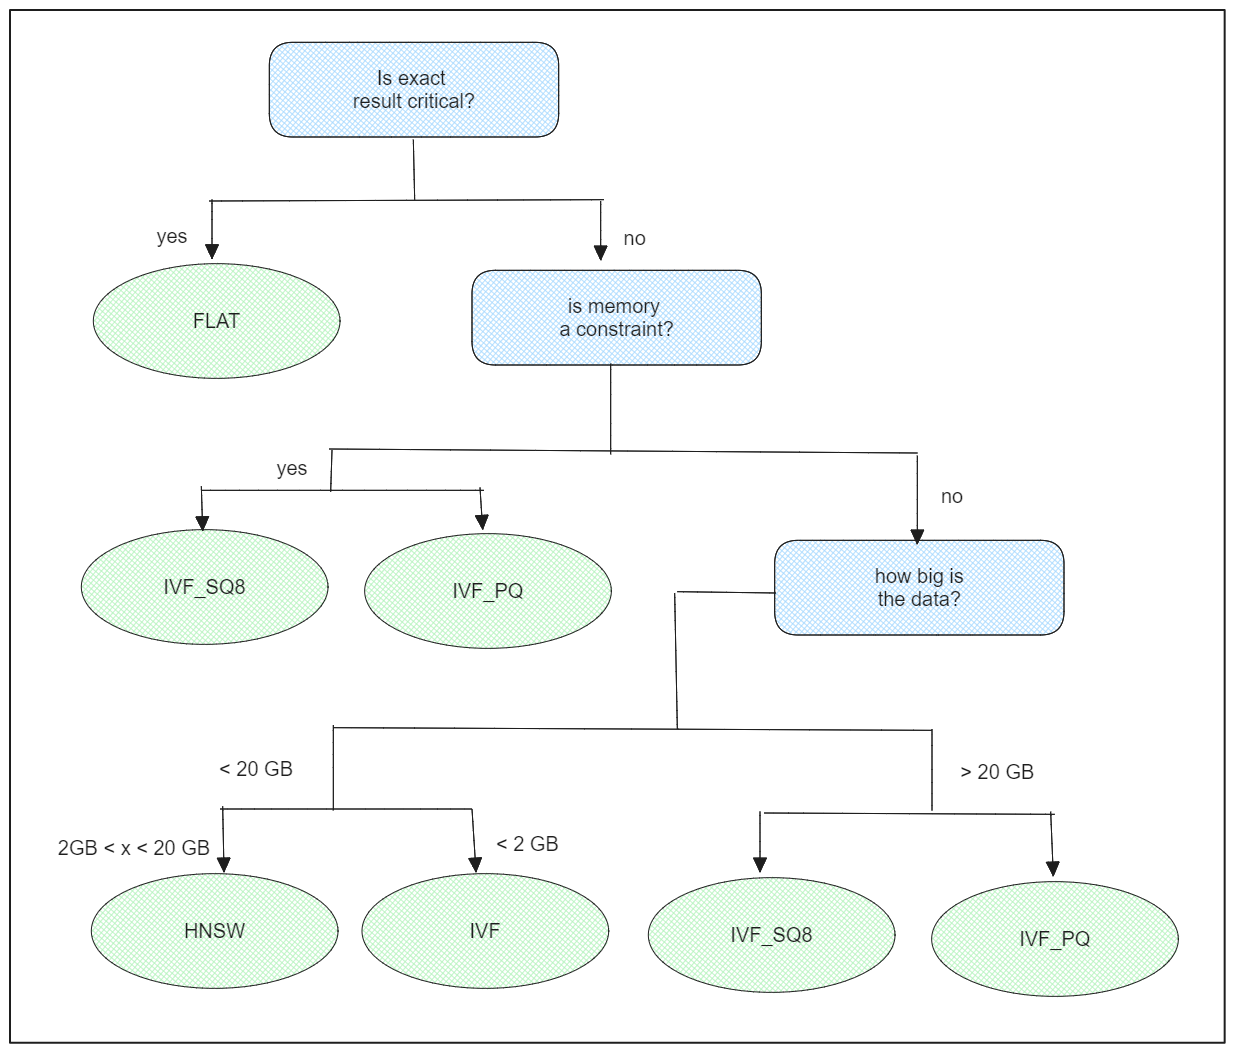

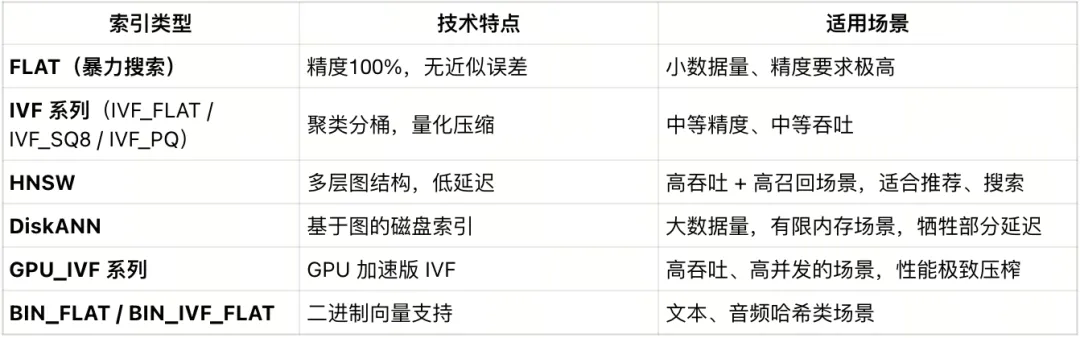

 ### Hands-on Exercise 3: 创建 HNSW 索引

 **任务**:
 1.  确保您在前一个练习 (`Hands-on Exercise 2`) 中使用的 `book_search_mc` Collection 存在，并且包含一些数据。
 2.  为该 Collection 的 `book_embedding` 字段创建一个 `HNSW` 索引。
 3.  **选择度量类型**: `L2`。
 4.  **选择 HNSW 参数**:
     *   `M`: 16
     *   `efConstruction`: 200
 5.  发送创建索引的请求。
 6.  使用 `client.list_indexes()` 检查索引是否已在 Collection 上列出。
 7.  使用 `client.get_index_build_progress()` 查看索引的构建进度（至少能看到 `total_rows` 和 `indexed_rows`）。
 8.  （可选）如果数据量不大，可以尝试使用 `client.wait_for_index_build_complete()` 等待索引完成。